In [2]:
import pandas as pd
import geopandas as gp
import pylab as pl
import numpy as np
import json
from geopandas import GeoDataFrame as gdf
from shapely.geometry import Point

%matplotlib inline

In [3]:
user_jsons = []
with open("data/2017-10-17_Police_tweets.json", 'rb') as f:
    for line in f:
        while True:
            try:
                jfile = json.loads(line)
                break
            except ValueError:
                # Not yet a complete JSON value
                line += next(f)
        user_jsons.append(jfile)

## grabbing the coordinates from the json file to make a Point object

In [5]:
longs = []
lats = []
name = []
for i in range(len(user_jsons)):
    if user_jsons[i]["coordinates"] is not None:
        longs.append(user_jsons[i]["coordinates"]["coordinates"][0])
        lats.append(user_jsons[i]["coordinates"]["coordinates"][1])
        name.append(user_jsons[i]["user"]["screen_name"])

In [6]:
myDict = {"longs": longs, "lats": lats, "name":name}
df = pd.DataFrame(myDict)

In [7]:
geometry = [Point(xy) for xy in zip(df.longs, df.lats)]

## Here I make the the tweets and states geodataframes

In [8]:
df = df.drop(['longs', 'lats'], axis=1)
crs = {'init': 'epsg:4326'}
tweets = gp.GeoDataFrame(df, crs=crs, geometry=geometry)
states = gp.read_file("data/states/cb_2016_us_state_500k.shp")


In [9]:
tweets = tweets.to_crs(states.crs)

In [10]:
tweets.head()

,name,geometry
0,Realsurfshop,POINT (-119.980975 34.58665556)
1,_EdwardNunez_,POINT (-119.72972051 36.48863024)
2,KYUTIEPIEKYU,POINT (-117.228 33.9431)
3,drvolks,POINT (-122.57427 37.89411)
4,SCHJobs,POINT (-122.1802812 37.3813444)


In [44]:
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
index_left,,,,,,,,,,
0,01,01779775,0400000US01,01,AL,Alabama,00,131173688951,4593686489,"(POLYGON ((-88.053375 30.506987, -88.051087999..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1477946266785,245390495931,"(POLYGON ((-134.737262 58.261354, -134.73441 5..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.816294 32.508038, -114.814321 3..."
3,05,00068085,0400000US05,05,AR,Arkansas,00,134771517596,2960191698,"POLYGON ((-94.6178329666013 36.4994141203285, ..."
4,06,01779778,0400000US06,06,CA,California,00,403501101370,20466718403,"(POLYGON ((-118.604415 33.478552, -118.598783 ..."


## I join the two dataframes two determine where and how many tweets come from each state, it will be more  useful most likely to a California shapefile instead

In [18]:
gp.sjoin?

In [11]:
joined = gp.sjoin(states, tweets, op='intersects', how='inner')

In [12]:
counts = joined.groupby('STUSPS').size()

In [13]:
counts = counts.to_dict()

In [14]:
counts.keys()

[u'OK', u'TX', u'CA', u'NC', u'MI', u'DC', u'NY', u'KY']

In [15]:
def get_count(x):
    if x in counts.keys():
        return counts[x]
    else:
        return 0

In [16]:
states['counts'] = states['STUSPS'].apply(get_count)

In [17]:
states['counts'] = states['counts'] / sum(states['counts'])

In [18]:
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,counts
index_left,,,,,,,,,,,
0,01,01779775,0400000US01,01,AL,Alabama,00,131173688951,4593686489,"(POLYGON ((-88.053375 30.506987, -88.051087999...",0.000000
1,02,01785533,0400000US02,02,AK,Alaska,00,1477946266785,245390495931,"(POLYGON ((-134.737262 58.261354, -134.73441 5...",0.000000
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.816294 32.508038, -114.814321 3...",0.000000
3,05,00068085,0400000US05,05,AR,Arkansas,00,134771517596,2960191698,"POLYGON ((-94.6178329666013 36.4994141203285, ...",0.000000
4,06,01779778,0400000US06,06,CA,California,00,403501101370,20466718403,"(POLYGON ((-118.604415 33.478552, -118.598783 ...",0.995342


(0, 60)

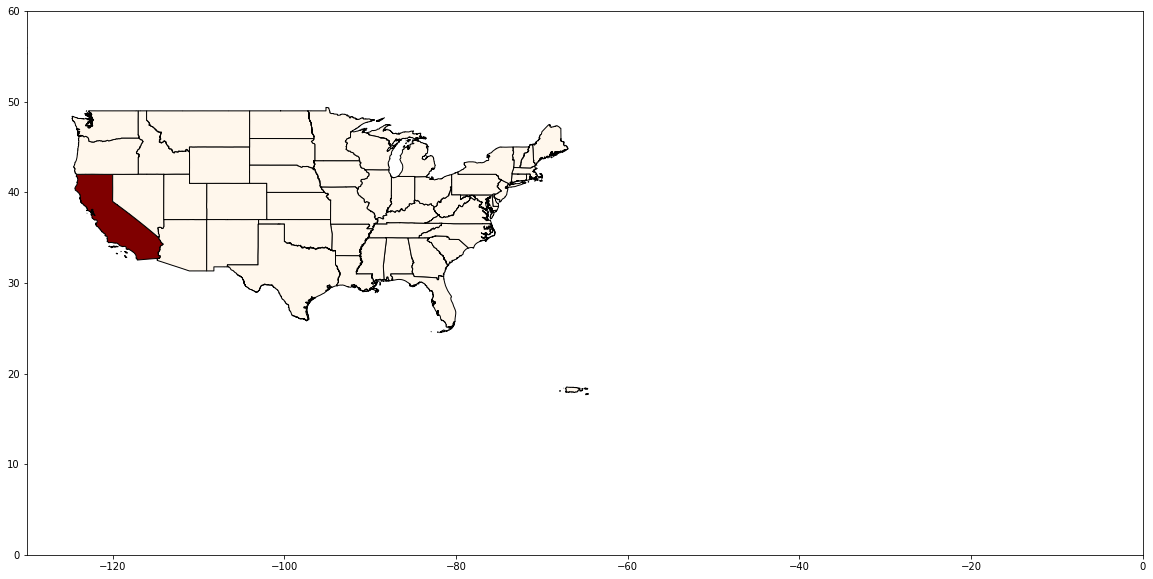

In [19]:
ax = pl.figure(figsize=(20,10)).add_subplot(111)
ax = states.plot(column='counts',cmap='OrRd', edgecolor='black', ax=ax);
ax.set_xlim(-130, 0)
ax.set_ylim(0, 60)


(0, 60)

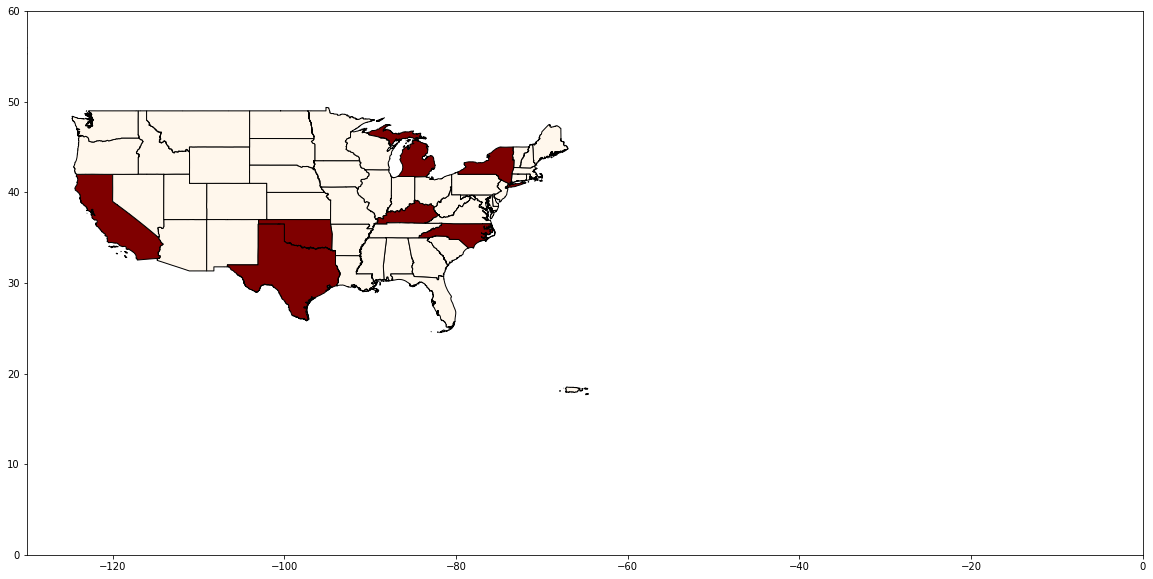

In [20]:
ax = pl.figure(figsize=(20,10)).add_subplot(111)
ax = states.plot(column='counts',cmap='OrRd', edgecolor='black', ax=ax, scheme='quantiles');
ax.set_xlim(-130, 0)
ax.set_ylim(0, 60)